##  Trading View Report: 1 - Normalizing Data Attributes

It can be useful to create a context space for data attributes describing the behavior of an asset.

One way that statisticians do this is by normalization.

In the example below, data that was retrieved from Trading View is normalized, then some additional attributes created after normalization.
The attributes are intended to help us understand the behavior in ways that may indicate what will happen next.

Technical analysts have been known to make a trend line by connecting the lows.  Here a reregression line is used because it also considers highs.

The first thing we have to do is import some packages and the data.

In [1]:
import pandas as pd
import numpy as np
import calendar
import datetime
import matplotlib.pyplot as plt  # To visualize

from sklearn.linear_model import LinearRegression

file = 'KRAKEN_ETHUSDT, 15 12292020.csv'
coin = 'eth'
period = '15min'
endpoint = '12292020'

df = pd.read_csv(file)
df.head(3)

,time,open,high,low,close,Volume,Volume MA,K,D,RSI,Histogram,MACD,Signal
0,1608736500,612.60,612.73,612.60,612.73,4.300000,41.950269,68.746359,68.705771,51.243173,0.559612,-0.185772,-0.745384
1,1608737400,610.21,611.33,610.21,611.33,12.253819,42.186619,56.464592,64.175492,49.199496,0.439291,-0.196270,-0.635561
2,1608738300,613.00,613.00,603.57,606.26,10.997087,33.643366,34.597059,53.269337,42.577076,0.023086,-0.606703,-0.629789


A normalization function is created below.  

A denormalization function is included so that any predictions made from normalized data can be understood in the actual context of the data.

It is more practical to estimate the direction, and possibly magnitude of future events than it would be to estimate exact values.
For the sake of understanding trends and magnitude, we don't need to know the actual values, so the normalized context is sufficient. 

In [2]:
def normalize_data(data):
    # df on input should contain only one column with the price data (plus dataframe index)
    min = data.min()
    max = data.max()
    x = data 
    
    # time series normalization part
    # y will be a column in a dataframe
    y = (x - min) / (max - min)
    
    return y

In [3]:
def denormalize_data(datan, data):
    # df on input should contain only one column with the price data (plus dataframe index)
    min = data.min()
    max = data.max()
    x2 = datan 
    
    # time series normalization part
    # y will be a column in a dataframe
    y2 = x2 * (max - min) + min
    
    return y2

With the data normalized, we can add some attributes to the data set.

Here a date is created because the unix timestamp doesn't make much sense to a human.
The previous close is just the close, shifted.
The difference is just the change in value compared to previous close.
Normalization is accomplished by applying the function defined above to attributes of the data set.
Some indicators that tell us about the event history are added for machine learning contexts.
Moving averages are created using a rolling mean applied to several intervals.

In [4]:
df['date'] = pd.to_datetime(df['time'],unit='s')
df['p_close'] = df.close.shift(1)
df['difference'] = df.close - df.p_close
df['close_norm'] = normalize_data(df.close)
df['vol_norm'] = normalize_data(df.Volume)
df['diff_norm'] = normalize_data(df.difference)
df['de_norm_diff'] = denormalize_data(df.diff_norm, df.difference)
df['direction'] = df['difference'].apply(lambda x: 'pos' if x >= 0 else 'neg')
#df['prev_dir'] = 
df['continue'] = df['direction'] == df['direction'].shift(1)

df['moving_5'] = df.close_norm.rolling(5).mean()
df['moving_8'] = df.close_norm.rolling(8).mean()
df['moving_13'] = df.close_norm.rolling(13).mean()

In [5]:
df.tail(3)

,time,open,high,low,close,Volume,Volume MA,K,D,RSI,...,difference,close_norm,vol_norm,diff_norm,de_norm_diff,direction,continue,moving_5,moving_8,moving_13
600,1609294500,736.26,738.76,736.26,738.76,1.489931,19.694042,34.633587,47.919333,60.142537,...,3.94,0.948347,0.000317,0.582688,3.94,pos,False,0.945913,0.952853,0.936487
601,1609295400,738.92,742.60,737.67,742.60,43.208121,21.520217,38.447584,38.831118,64.587694,...,3.84,0.969977,0.009321,0.580016,3.84,pos,True,0.947727,0.954247,0.942038
602,1609296300,740.47,740.47,740.47,740.47,0.674545,21.484606,44.966824,39.349332,60.553561,...,-2.13,0.957979,0.000141,0.420518,-2.13,neg,False,0.949428,0.953283,0.946687


The regression line is created by choosing the (normalized) attribute that should be considered over time.

With the values identified using scikit learn, an attribute is added to the data set that we can visualize with the other data.

In [6]:
data = df[['time', 'close_norm']]

X = data.iloc[:, 0].values.reshape(-1, 1)  # values converts it into a numpy array
Y = data.iloc[:, 1].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

In [7]:
df['reg'] = Y_pred

Using matplotlib, a chart is created to show us what the data looks like.

C:\Users\alexj\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


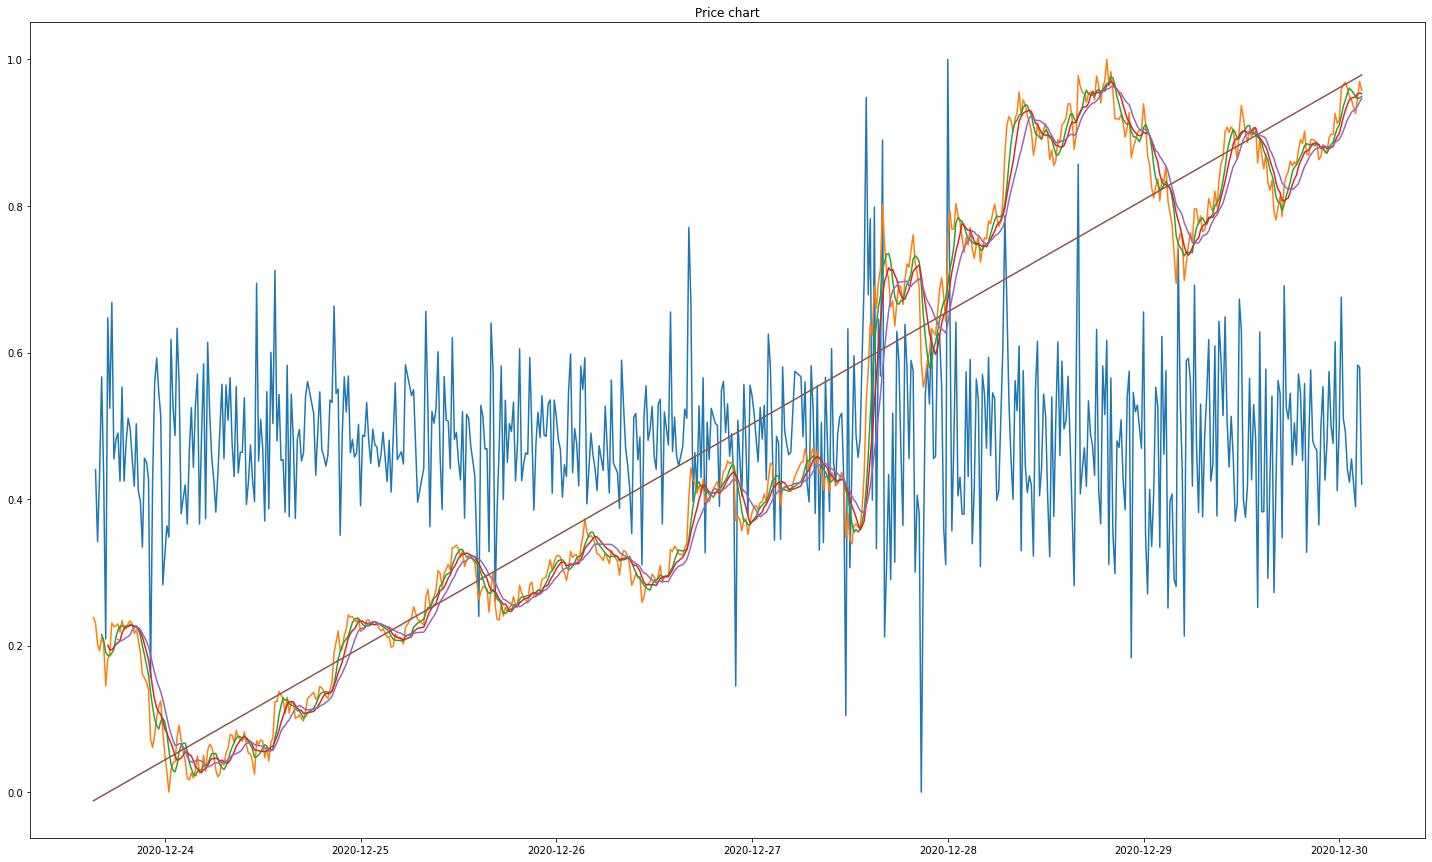

In [8]:
%matplotlib inline
# plot difference
plt.figure(figsize=(25,15))
plt.plot(df['date'], df['diff_norm'])
plt.plot(df['date'], df['close_norm'])
plt.plot(df['date'], df['moving_5'])
plt.plot(df['date'], df['moving_8'])
plt.plot(df['date'], df['moving_13'])
plt.plot(df['date'], df['reg'])
#plt.plot(df['date'],])
plt.title('Price chart')
plt.show()

To use the normalized data in other contexts, a new data set is constructed, then exported to a csv file.

In [9]:
normalized_data = df[['date', 'close', 'p_close', 'difference', 'Volume', 'close_norm', 'vol_norm', 'diff_norm',
                      'moving_5', 'moving_8', 'moving_13', 'reg']]

In [10]:
normalized_data.to_csv(f'{coin}_{period}_{endpoint}_normalized.csv', index=False)